In [1]:
import os

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cdcm import *
from cdcm_utils.derivatives import set_derivative
from figures import *

Author: Sreehari Manikkan

Date: 08/01/2023

Consider a system with name `diff_sys` as shown below.

In [2]:
diff_sys_graph().show('dsg.html')

dsg.html


The functional relationships are as follow:
$$
y = t_3sin(x)\\
t_3=k \cdot t_2\\
t_2=cos(x)\\
x^{t+1} = x^t+e^{t_1-x_t} \cdot r \cdot dt\\
$$
<br> $k, t_1$, $r$, $dt$ are `Parameters` of the system.

The CDCM system is created in the cell below. The `diff_sys` is created as consisting of two subsystems: `clock_system` and `some_sys`

In [3]:
class SomeSystem(System):

    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

    def define_internal_nodes(self, dt, **kwargs):
        
        y = Variable(
            name='y',
            value=1.,
            units=None
            )
        
        x = State(
            name='x',
            value=1.,
            units=None
            )

        r = Parameter(
            name='r',
            value=0.1,
            units=None,
        )
        
        t1 = Parameter(
            name='t1',
            value=0.01,
            units=None,
            )
        
        t2 = Variable(
            name='t2',
            value=1.,
            units=None,
            )
        
        t3 = Variable(
            name='t3',
            value=1.,
            units=None,
            )
        
        k = Parameter(
            name='k',
            value=2.,
            units=None,
            )
        
        @make_function(t2)
        def calc_t2(x=x):
            return jnp.cos(x)
        
        @make_function(t3)
        def calc_t3(t2=t2,k=k):
            return k*t2
        
        @make_function(x)
        def calc_x(x=x,r=r,dt=dt, t1=t1):
            return x+jnp.exp(t1-x)*r*dt
        
        @make_function(y)
        def calc_y(x=x, t3=t3):
            return t3*jnp.sin(x)
dt = 1.0
with System(name='diff_sys') as diff_sys:
    clock = make_clock(dt=dt, units='seconds')
    some_sys = SomeSystem(name='some_sys', dt=clock.dt)

In [4]:
ds, ss = diff_sys, some_sys
### setting first order derivatives ####
set_derivative(ds,ss.x, ss.t1,"dxdt1")
set_derivative(ds,ss.x, ss.r,"dxdr")
set_derivative(ds,ss.y,ss.x,"dydx")
set_derivative(ds,ss.y,ss.k,"dydk")
set_derivative(ds,ss.t3,ss.t2,"dt3dt2")

## setting second order derivatives #####
set_derivative(ds,ds.dydx,ss.x,"d2ydx2")
set_derivative(ds,ds.dydx,ss.k,"d2ydxdk")
set_derivative(ds,ds.dydk,ss.x,"d2ydkdx")
set_derivative(ds,ds.dxdr,ss.t1,"d2xdrdt1")
set_derivative(ds,ds.dxdt1,ss.r,"d2xdt1dr")

## setting third order derivative #####
set_derivative(ds,ds.d2ydx2,ss.x,"d3ydx3")

### Simulation and results comparison ###

In [5]:
simulator = Simulator(ds)

#Event 1
def change_r():
    ss.r.value = 1.5

# Event 2
def change_k():
    ss.k.value = 10.

#Event 3
def change_t1():
    ss.t1.value = 0.1

#Event 4
def change_x():
    ss.x.value = 1.

simulator.add_event(10.5*dt, change_r)
simulator.add_event(25.5*dt, change_k)
simulator.add_event(35.5*dt, change_t1)
simulator.add_event(40.3*dt, change_x)

In [6]:
max_steps = 50
file_name = "differentiable_cdcm_egs.h5"

if os.path.exists(file_name):
    os.remove(file_name)

result_saver = SimulationSaver(file_name, diff_sys, max_steps=max_steps)
import time
now = time.time()
for i in range(max_steps):
    simulator.forward()
    result_saver.save()
    simulator.transition()
print('elapsed time',time.time()-now)

elapsed time 7.3317461013793945


In [7]:
def fetch_saved_data(var_name, sys):
    node = getattr(sys, var_name)
    if sys.name == 'diff_sys':
        path="diff_sys/"+node.name
    else:
        path="diff_sys/some_sys/"+node.name
    res = result_saver.file_handler[path][:]
    return res

In [8]:
def plot_res(result_saver):
    ss = some_sys
    ds = diff_sys
    x = fetch_saved_data("x",ss)
    y = fetch_saved_data("y",ss)
    t2 = fetch_saved_data("t2",ss)
    t3 = fetch_saved_data("t3",ss)
    k = fetch_saved_data("k",ss)
    r = fetch_saved_data("r",ss)
    t1 = fetch_saved_data("t1",ss)

    
    dxdt1_appx = fetch_saved_data("dxdt1",ds)
    dxdr_appx = fetch_saved_data("dxdr",ds)

    dydx_appx = fetch_saved_data("dydx",ds)
    dydk_appx = fetch_saved_data("dydk",ds)
    dt3dt2_appx = fetch_saved_data("dt3dt2",ds)
    
    d2ydx2_appx = fetch_saved_data("d2ydx2",ds)
    d2ydxdk_appx = fetch_saved_data("d2ydxdk",ds)
    d2ydkdx_appx = fetch_saved_data("d2ydkdx",ds)
    d2xdt1dr_appx = fetch_saved_data("d2xdt1dr",ds)
    d2xdrdt1_appx = fetch_saved_data("d2xdrdt1",ds)
    d3ydx3_appx = fetch_saved_data("d3ydx3",ds)
    
    
    dydx_tr, dydt3_tr = k*np.cos(2*x), np.sin(x)-(t3/k)*(1/np.tan(x))
    dydt2_tr, dt3dt2_tr = k*np.sin(x)-t3*(1/np.tan(x)), k*np.ones(max_steps)
    dt2dx_tr, dt3dx_tr, d2ydx2_tr = -np.sin(x), -k*np.sin(x), -2*k*np.sin(2*x)
    d2ydt3dx_tr = np.cos(x)-(1/k)*(t3*-(1/np.sin(x))**2-k*np.sin(x)*(1/np.tan(x)))
    d2ydxdt3_tr,d2ydxdt2_tr, d2ydt2dx_tr = 4*np.cos(x),4*k*np.cos(x), k*d2ydt3dx_tr
    d3ydx3_tr,dydk_tr,d2ydkdx_tr = -4*k*np.cos(2*x),0.5*np.sin(2*x), np.cos(2*x)
    dxdt1_tr, dxdr_tr = np.exp(t1-x)*r*dt,np.exp(t1-x)*dt
    d2xdrdt1_tr = np.exp(t1-x)*dt*(1-dxdt1_tr)
    
    time = np.arange(max_steps)
    fig, ax = plt.subplots(3,3,figsize=(15,10), facecolor='w', edgecolor='k')
    ax[0,0].plot(time,dydx_appx,'*', label='dydx_app')
    ax[0,0].plot(time,dydx_tr, label='dydx_tr')
    ax[0,0].legend()
    ax[0,1].plot(time,d2ydx2_appx,'*', label='d2ydx2_app')
    ax[0,1].plot(time,d2ydx2_tr, label='d2ydx2_tr')
    ax[0,1].legend()
    ax[0,2].plot(time,dxdt1_appx,'*', label='dxdt1_app')
    ax[0,2].plot(time,dxdt1_tr, label='dxdt1_tr')
    ax[0,2].legend()
    ax[1,0].plot(time,d2ydxdk_appx,'*', label='d2ydxdk_app')
    ax[1,0].plot(time,d2ydkdx_appx,'+', label='d2ydkdx_app')
    ax[1,0].plot(time,d2ydkdx_tr, label='d2ydt3dx_tr')
    ax[1,0].legend()
    ax[1,1].plot(time,dydk_appx,'*', label='dydk_app')
    ax[1,1].plot(time,dydk_tr, label='dydk_tr')
    ax[1,1].legend()
    ax[1,2].plot(time,dxdr_appx,'*', label='dxdr_app')
    ax[1,2].plot(time,dxdr_tr, label='dxdr_tr')
    ax[1,2].legend()
    ax[2,0].plot(time,d3ydx3_appx,'*', label='d3ydx3_app')
    ax[2,0].plot(time,d3ydx3_tr, label='d3ydx3_tr')
    ax[2,0].legend()
    ax[2,1].plot(time,dt3dt2_appx,'*', label='dt3dt2_app')
    ax[2,1].plot(time,dt3dt2_tr, label='dt3dt2_tr')
    ax[2,1].legend()
    ax[2,2].plot(time,d2xdt1dr_appx,'*', label='d2xdt1dr_app')
    ax[2,2].plot(time,d2xdrdt1_appx,'+', label='d2xdrdt1_app')
    ax[2,2].plot(time,d2xdrdt1_tr, label='d2xdrdt1_tr')
    ax[2,2].legend()

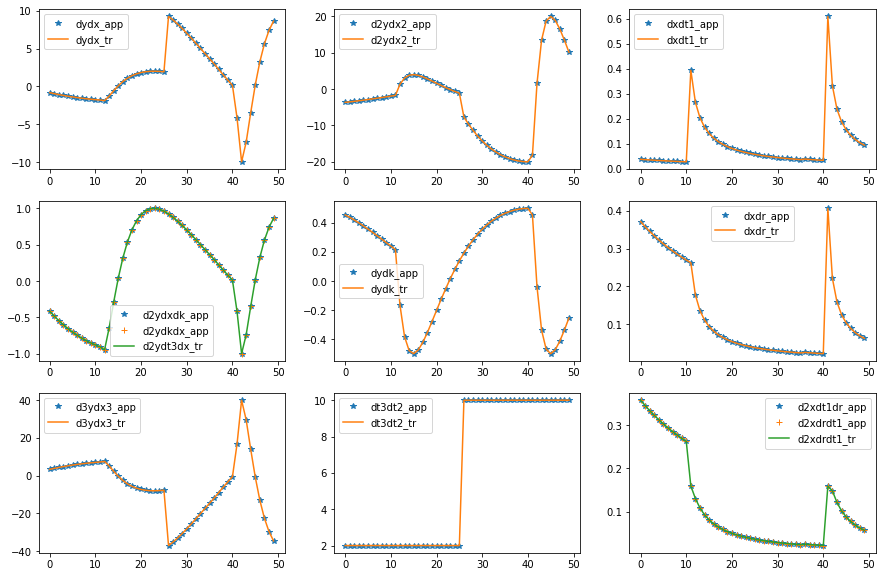

In [9]:
plot_res(result_saver)